# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
#%pip install torchvision --user
!pip install -U tensorflow
!pip install -U tqdm
!pip install tensorflow_datasets
!pip install "tensorflow_hub>=0.6.0"

ERROR: Could not find a version that satisfies the requirement tensorflow
ERROR: No matching distribution found for tensorflow


In [2]:
# TODO: Make all other necessary imports.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as display
from PIL import Image
import numpy as np
import pandas as pd
import json
import seaborn
import glob,random
print("Imported required packages")

Imported required packages


In [2]:
import zipfile
with zipfile.ZipFile('flowers.zip', 'r') as zip_ref:
    zip_ref.extractall('flowers_new')

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [3]:
# Download data to default local directory "~/tensorflow_datasets"
#!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums=True --datasets=oxford_flowers102
#skip the above command as flowers are copied into workspace

In [4]:
dataset, info = tfds.load("oxford_flowers102",with_info=True,download=True)

In [5]:
train_dataset = dataset['train']
test_dataset = dataset['test']
valid_dataset = dataset['validation']

## Explore the Dataset

In [6]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [7]:
train_egs = info.splits['train'].num_examples
test_egs = info.splits['test'].num_examples
val_egs = info.splits['validation'].num_examples
print("There are {} images in the training set".format(train_egs))
print("There are {} images in the training set".format(val_egs))
print('There are {} images in the test set'.format(test_egs))

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = info.features['label'].num_classes

print('There are {} classes in our dataset'.format(num_classes))

There are 1020 images in the training set
There are 1020 images in the training set
There are 6149 images in the test set
There are 102 classes in our dataset


In [8]:
number=1
for img in train_dataset.take(3):
    image,label,shape = img['image'], img['label'], img['image'].shape
    print(('Image-{2} label is : {0} and shape is : {1}').format(label,shape,number))
    number=number+1

Image-1 label is : 72 and shape is : (500, 667, 3)
Image-2 label is : 84 and shape is : (500, 666, 3)
Image-3 label is : 70 and shape is : (670, 500, 3)


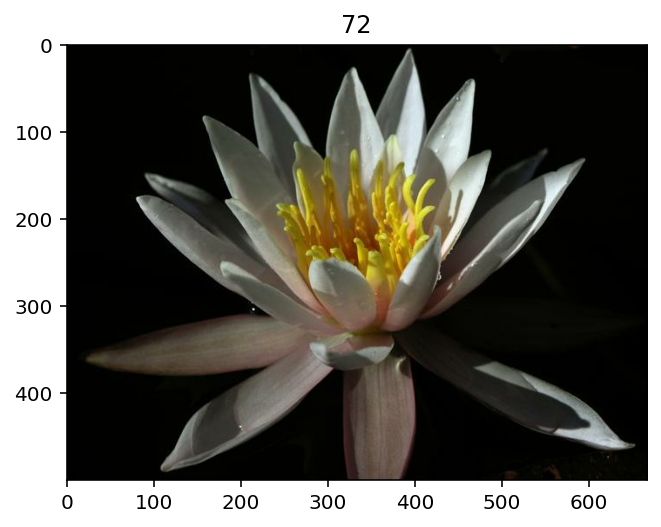

In [9]:
for img in train_dataset.take(1):
    image,label = img['image'], img['label']
    plt.imshow(image.numpy())
    plt.title(label.numpy())

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [10]:
# checking the minimum and maximum label value in the "train_dataset"
minx = 1000
maxx = -1
for i in train_dataset.take(1000):
    minx = min(i['label'].numpy(), minx)
    maxx = max(i['label'].numpy(), maxx)
minx, maxx

(0, 101)

In [11]:
# checking the minimum and maximum label value in the "test_dataset"
minx = 1000
maxx = -1
for i in test_dataset.take(1000):
    minx = min(i['label'].numpy(), minx)
    maxx = max(i['label'].numpy(), maxx)
minx, maxx

(0, 101)

In [12]:
# checking the minimum and maximum label value in the "valid_dataset"
minx = 1000
maxx = -1
for i in valid_dataset.take(1000):
    minx = min(i['label'].numpy(), minx)
    maxx = max(i['label'].numpy(), maxx)
minx, maxx

(0, 101)

In [13]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [14]:
print(json.dumps(class_names, indent=2, sort_keys=True))

{
  "1": "pink primrose",
  "10": "globe thistle",
  "100": "blanket flower",
  "101": "trumpet creeper",
  "102": "blackberry lily",
  "11": "snapdragon",
  "12": "colt's foot",
  "13": "king protea",
  "14": "spear thistle",
  "15": "yellow iris",
  "16": "globe-flower",
  "17": "purple coneflower",
  "18": "peruvian lily",
  "19": "balloon flower",
  "2": "hard-leaved pocket orchid",
  "20": "giant white arum lily",
  "21": "fire lily",
  "22": "pincushion flower",
  "23": "fritillary",
  "24": "red ginger",
  "25": "grape hyacinth",
  "26": "corn poppy",
  "27": "prince of wales feathers",
  "28": "stemless gentian",
  "29": "artichoke",
  "3": "canterbury bells",
  "30": "sweet william",
  "31": "carnation",
  "32": "garden phlox",
  "33": "love in the mist",
  "34": "mexican aster",
  "35": "alpine sea holly",
  "36": "ruby-lipped cattleya",
  "37": "cape flower",
  "38": "great masterwort",
  "39": "siam tulip",
  "4": "sweet pea",
  "40": "lenten rose",
  "41": "barbeton daisy"

In [15]:
#Class names contain index from 1 to 102, whereas the datasets have label indices from 0 to 101, hence remapping
class_names_new = dict()
for key in class_names:
    class_names_new[str(int(key)-1)] = class_names[key]

In [16]:
print(class_names_new)

{'20': 'fire lily', '2': 'canterbury bells', '44': 'bolero deep blue', '0': 'pink primrose', '33': 'mexican aster', '26': 'prince of wales feathers', '6': 'moon orchid', '15': 'globe-flower', '24': 'grape hyacinth', '25': 'corn poppy', '78': 'toad lily', '38': 'siam tulip', '23': 'red ginger', '66': 'spring crocus', '34': 'alpine sea holly', '31': 'garden phlox', '9': 'globe thistle', '5': 'tiger lily', '92': 'ball moss', '32': 'love in the mist', '8': 'monkshood', '101': 'blackberry lily', '13': 'spear thistle', '18': 'balloon flower', '99': 'blanket flower', '12': 'king protea', '48': 'oxeye daisy', '14': 'yellow iris', '60': 'cautleya spicata', '30': 'carnation', '63': 'silverbush', '67': 'bearded iris', '62': 'black-eyed susan', '68': 'windflower', '61': 'japanese anemone', '19': 'giant white arum lily', '37': 'great masterwort', '3': 'sweet pea', '85': 'tree mallow', '100': 'trumpet creeper', '41': 'daffodil', '21': 'pincushion flower', '1': 'hard-leaved pocket orchid', '53': 'sun

In [17]:
len(class_names_new.keys())

102

In [18]:
print(class_names)

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

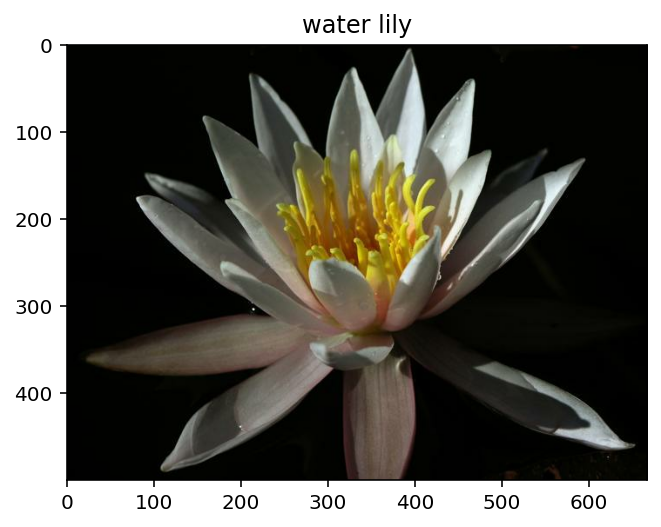

In [19]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for img in train_dataset.take(1):
    image,label = img['image'], img['label']
    plt.imshow(image.numpy())
    plt.title(class_names_new[str(label.numpy())])

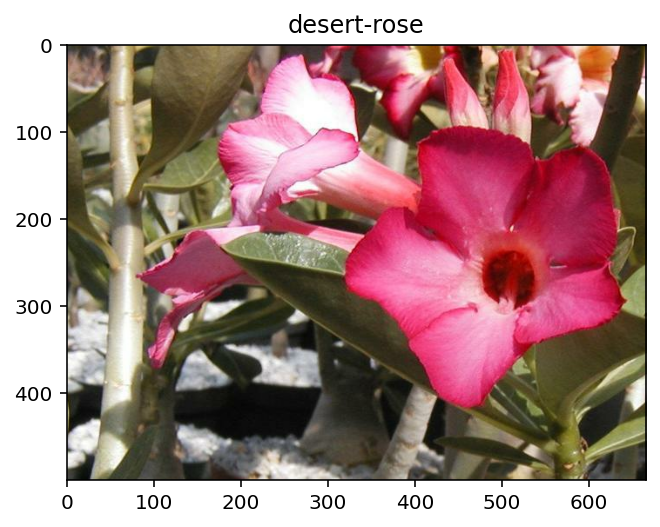

In [20]:
# TODO: Plot 1 image from the training set. Set the title 
# of the plot to the corresponding class name. 

for img in train_dataset.take(2):
    image,label = img['image'], img['label']
    plt.imshow(image.numpy())
    plt.title(class_names_new[str(label.numpy())])

In [21]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! 

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model. 

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [22]:
# TODO: Build and train your network.

def build_model():
    # Load the MobileNet pre-trained network from TensorFlow Hub
    mobilenet_class_map_file = "download.tensorflow.org/data/ImageNetLabels.txt"
    feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v1_050_160/classification/4"
    feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=IMG_SHAPE, trainable=False)
    
    model = tf.keras.Sequential([feature_extractor_layer,
                                 tf.keras.layers.Dense(600,activation='relu'),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(300,activation='relu'),
                                 tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(num_classes, activation='softmax')
                                ])
    print(model.summary())
    
    return model

In [23]:
def train_model():
    model = build_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    
    callback_path = "train_model/"+"/image_classifier_trained_model.hdf5"
    checkpoint = tf.keras.callbacks.ModelCheckpoint(callback_path, save_best_only=True, save_weights_only=False)
    hist_call_back = model.fit(training_batches, epochs=30, callbacks=[checkpoint], validation_data=validation_batches)
    return model, hist_call_back

In [24]:
BATCH_SIZE = 35

In [25]:
# Data Normalisation : The training, validation, and testing data is appropriately resized and normalized.
def format_image(img):
    label = img['label']
    label = tf.one_hot(label,num_classes)
    img = img['image']

    processed_image = tf.image.resize(img,(IMG_SIZE,IMG_SIZE))
    processed_image /= 255
    
    return processed_image, label

In [26]:
training_batches = train_dataset.shuffle(train_egs//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = valid_dataset.shuffle(train_egs//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = test_dataset.shuffle(train_egs//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

In [27]:
model, history = train_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              1343049   
_________________________________________________________________
dense (Dense)                (None, 600)               601200    
_________________________________________________________________
dropout (Dropout)            (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               180300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               30702     
Total params: 2,155,251
Trainable params: 812,202
Non-trainable params: 1,343,049
________________________________________

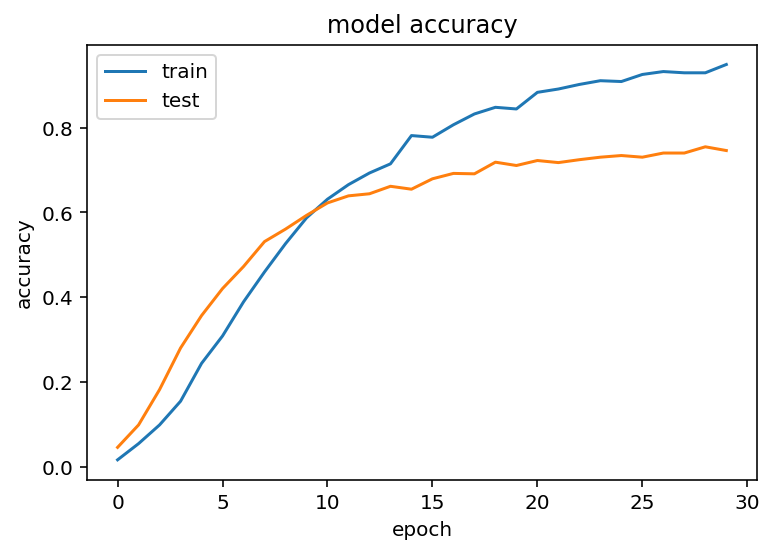

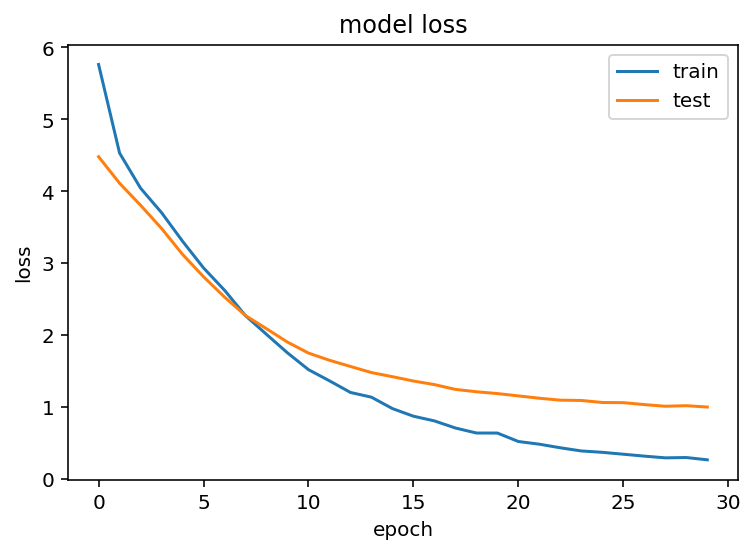

In [28]:
#Accuracy Plots

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

# Loss Plots

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()


## *Testing your Network*

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [29]:
loss,acc = model.evaluate(test_batches)

176/176 [==============================] - 44s 247ms/step - loss: 1.1068 - acc: 0.7190


In [30]:
print("Loss :",loss,"\nAccuracy :",acc)

Loss : 1.1067705154418945 
Accuracy : 0.7189787030220032


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [31]:
model_path = 'train_model/my_model.h5'
model.save(model_path)

## Load the Keras Model

Load the Keras model you saved above.

In [32]:
# TODO: Load the Keras model
loaded_model = tf.keras.models.load_model(model_path,custom_objects={'KerasLayer':hub.KerasLayer})
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              1343049   
_________________________________________________________________
dense (Dense)                (None, 600)               601200    
_________________________________________________________________
dropout (Dropout)            (None, 600)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               180300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 102)               30702     
Total params: 2,155,251
Trainable params: 812,202
Non-trainable params: 1,343,049
________________________________________

# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like: 

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function. 

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values. 

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [33]:
def process_image(numpy_image):
    print(numpy_image.shape)
    tensor_img = tf.image.convert_image_dtype(numpy_image, dtype=tf.int16, saturate=False)
    resized_img = tf.image.resize(numpy_image,(IMG_SIZE,IMG_SIZE)).numpy()
    norm_img = resized_img/255

    return norm_img

To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size. 

(500, 750, 3)


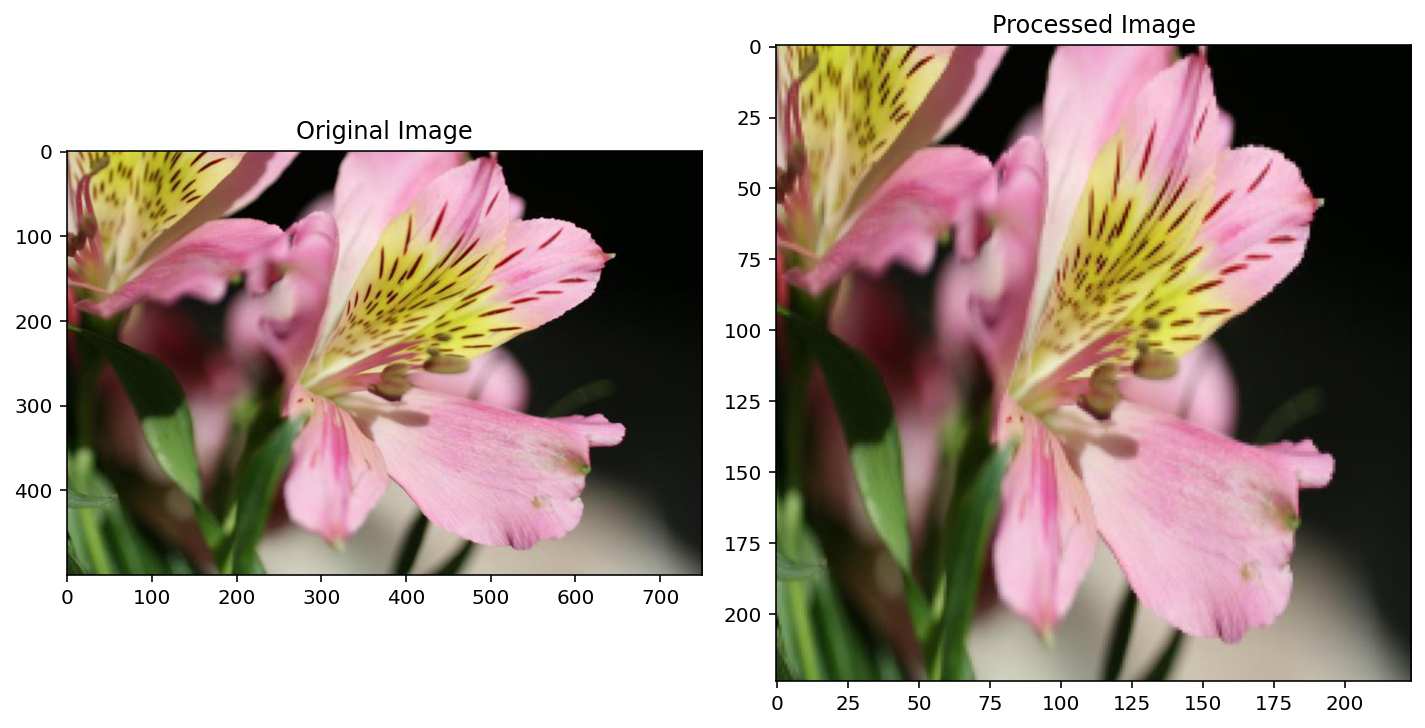

In [34]:
from PIL import Image

image_path = './images/test/image_04272.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

In [58]:
# TODO: Create the predict function
def predict(image_path, model, top_k):
    im = Image.open(image_path)
    test_image = np.asarray(im)
    processed_test_image = process_image(test_image)
    prediction = model.predict(np.expand_dims(processed_test_image, axis=0))
    top_values, top_indices = tf.math.top_k(prediction, top_k)
    print("These are the top propabilities",top_values.numpy()[0])
    print("top indices {0}".format(top_indices.numpy()[0]))
    top_classes = [class_names[str(value)] for value in top_indices.cpu().numpy()[0]]
    print('Of these top classes', top_classes)
    #return top_values.numpy()[0], top_classes
    return top_values.numpy()[0], top_indices.numpy()[0]

In [59]:
probs, classes = predict('./images/test/image_04256.jpg',loaded_model, 5)

(500, 563, 3)
These are the top propabilities [0.32435396 0.29830888 0.05273595 0.04449543 0.0346983 ]
top indices [80 33 64 45 42]
Of these top classes ['anthurium', 'love in the mist', 'silverbush', 'bolero deep blue', 'daffodil']


In [60]:
print(classes)
pred_label_names = [class_names_new[str(idx)] for idx in classes]
print('prediction labels:\n',pred_label_names)
print("prediction probabilities :\n",probs)
print('prediction classes:\n',classes)

[80 33 64 45 42]
prediction labels:
 ['frangipani', 'mexican aster', 'californian poppy', 'wallflower', 'sword lily']
prediction probabilities :
 [0.32435396 0.29830888 0.05273595 0.04449543 0.0346983 ]
prediction classes:
 [80 33 64 45 42]


# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`. 

In [61]:
# TODO: Plot the input image along with the top 5 classes
img_path_1 = './images/test/image_03994.jpg'
img_path_2 = './images/test/image_03996.jpg'
img_path_3 = './images/test/image_04012.jpg'
img_path_4 = './images/test/image_04014.jpg'

In [66]:
def plot_image(path, index):
    ax = plt.subplot(2, 2, index*2 + 1)
    
    img = Image.open(path)
    test_image = np.asarray(img)
    img = process_image(test_image)
    
    title = path.rsplit("/",1)[-1]
    plt.title(title)
    plt.imshow(img)
    
    # Make prediction
    probs, labels = predict(path, model, 5)
    print("probablities are {0}".format(probs))
    print(labels)
    
    # Get label names
    label_names = [class_names_new[str(idd)] for idd in labels]
    print(label_names)
    
    # Plot bar chart
    ax = plt.subplot(2, 2, index*2 + 2)
    ax.yaxis.tick_right()
    sns.barplot(x=probs, y=label_names, color=sns.color_palette()[0]);

(539, 500, 3)
(539, 500, 3)
These are the top propabilities [0.9027956  0.03254231 0.01202079 0.0111772  0.00497822]
top indices [11 53 28 70 72]
Of these top classes ['snapdragon', 'primula', 'stemless gentian', 'tree poppy', 'azalea']
probablities are [0.9027956  0.03254231 0.01202079 0.0111772  0.00497822]
[11 53 28 70 72]
["colt's foot", 'sunflower', 'artichoke', 'gazania', 'water lily']

second image

(500, 666, 3)
(500, 666, 3)
These are the top propabilities [0.12230461 0.10998163 0.07624057 0.06778001 0.06422306]
top indices [54 34 22  2 47]
Of these top classes ['sunflower', 'mexican aster', 'pincushion flower', 'hard-leaved pocket orchid', 'marigold']
probablities are [0.12230461 0.10998163 0.07624057 0.06778001 0.06422306]
[54 34 22  2 47]
['pelargonium', 'alpine sea holly', 'fritillary', 'canterbury bells', 'buttercup']


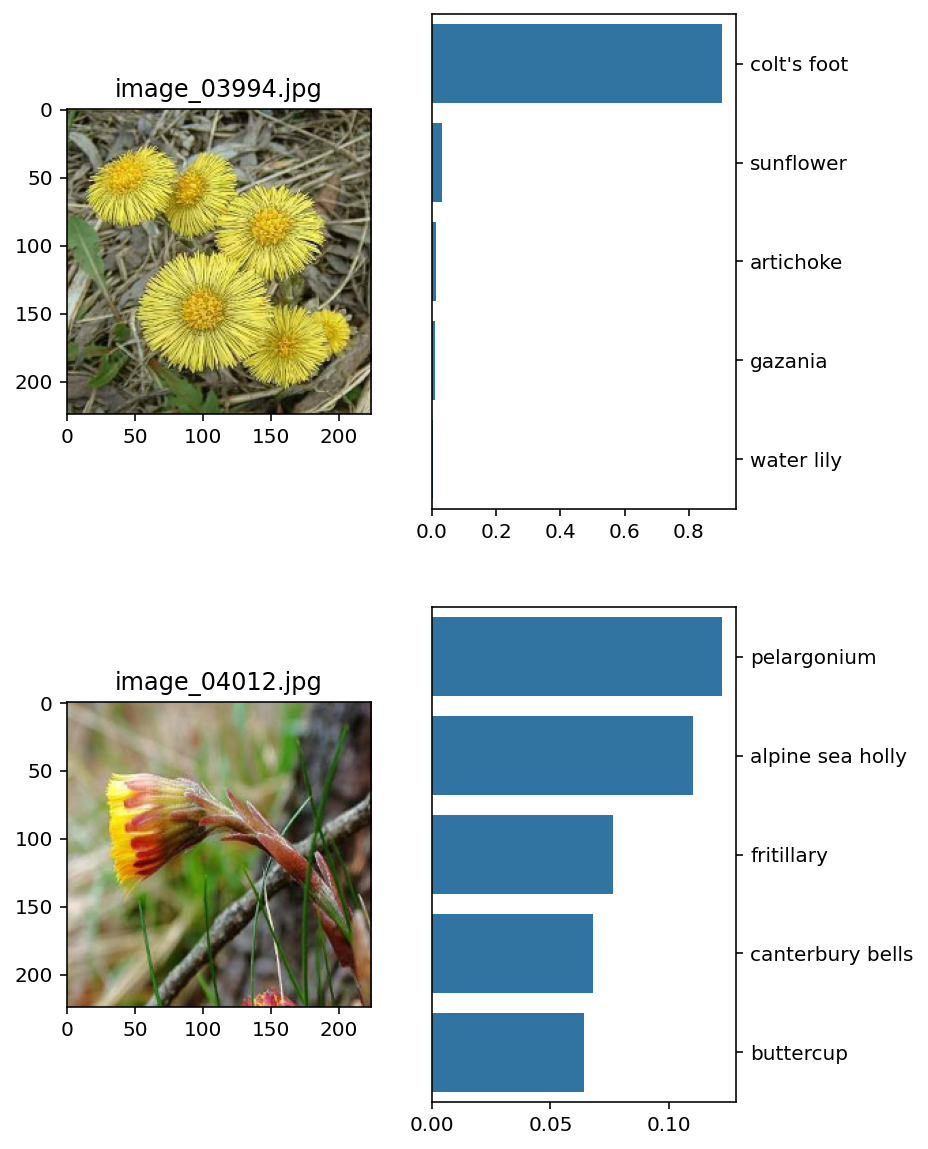

In [69]:
plt.figure(figsize = (6,10))
plot_image(img_path_1, 0)
print("\nsecond image\n")
plot_image(img_path_3, 1)
plt.show()

(591, 500, 3)
(591, 500, 3)
These are the top propabilities [0.90727526 0.03113736 0.01452932 0.00997647 0.00885473]
top indices [11 40 49 28 99]
Of these top classes ['snapdragon', 'lenten rose', 'oxeye daisy', 'stemless gentian', 'bromelia']
probablities are [0.90727526 0.03113736 0.01452932 0.00997647 0.00885473]
[11 40 49 28 99]
["colt's foot", 'barbeton daisy', 'common dandelion', 'artichoke', 'blanket flower']


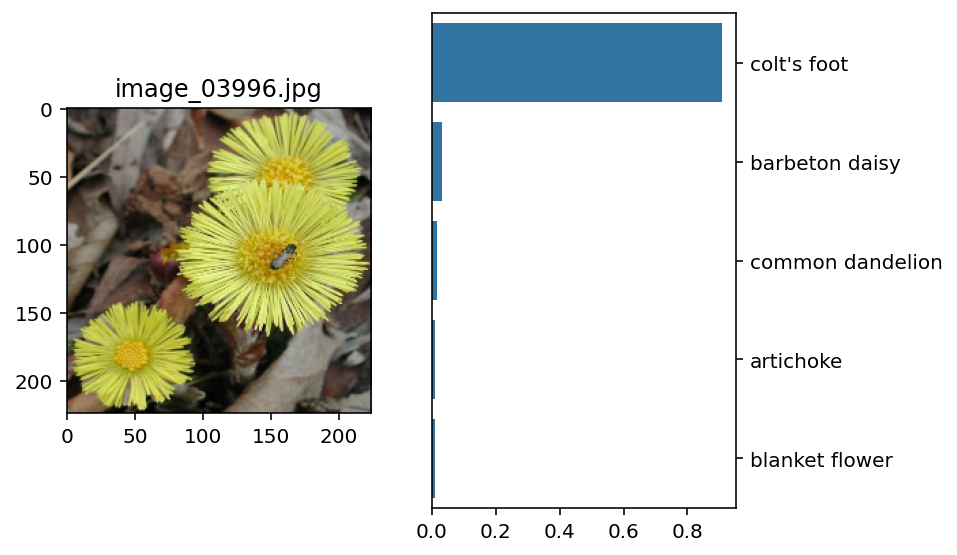

In [70]:
plt.figure(figsize = (6,10))
plot_image(img_path_2, 0)
#plot_image(img_path_4, 1)
#plt.show()

In [71]:
# Printing the outputs from the predict function for input image of orange_dahlia
print(probs)
print(classes)
print(pred_label_names)

[0.32435396 0.29830888 0.05273595 0.04449543 0.0346983 ]
[80 33 64 45 42]
['frangipani', 'mexican aster', 'californian poppy', 'wallflower', 'sword lily']


In [74]:
ls

 Volume in drive C is Acer
 Volume Serial Number is 504F-AC66

 Directory of C:\Users\VENKY_PC\OneDrive\Documents\ml_practice\image-classifier

17-01-2021  17:26    <DIR>          .
17-01-2021  17:26    <DIR>          ..
17-01-2021  17:22               153 .gitignore
13-01-2021  17:25    <DIR>          .ipynb_checkpoints
08-01-2021  13:13    <DIR>          assets
13-01-2021  18:03    <DIR>          images
13-01-2021  06:36    <DIR>          issue_snippets
08-01-2021  12:17             2,218 label_map.json
08-01-2021  13:08            12,121 model_train.py
17-01-2021  17:14             3,168 predict.py
08-01-2021  14:04         1,603,918 Project_Image_Classifier.html
13-01-2021  05:46         1,523,574 Project_Image_Classifier.ipynb
17-01-2021  17:26         3,299,901 Project_Image_Classifier_tensorflow_process.ipynb
08-01-2021  15:13               782 README.md
17-01-2021  16:21    <DIR>          train_model
               8 File(s)      6,445,835 bytes
               7 Dir(s)  23,668,